# initial data extraction

In [ ]:
import requests
import gzip
import shutil

# url = "https://www.minorplanetcenter.net/iau/ECS/MPCAT-OBS/NumObs.txt.gz"
url = "https://www.minorplanetcenter.net/iau/ECS/MPCAT-OBS/midmonth/UnnObs.txt.gz"
output_filename = "MPC_full_UnNumObs.txt"

try:
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with gzip.GzipFile(fileobj=response.raw, mode='rb') as gz_file:
        with open(output_filename, 'wb') as out_file:
            shutil.copyfileobj(gz_file, out_file)

    print(f"File downloaded and decompressed successfully to {output_filename}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")


In [111]:
filename = "MPC_full_UnNumObs.txt"
line_count = 0
progress_interval = 1_000_000  # Every 1 million lines

try:
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line_count += 1
            if line_count % progress_interval == 0:
                print(f"Processed {line_count:,} lines...")

    print(f"\nTotal number of lines: {line_count:,}")
except FileNotFoundError:
    print(f"File not found: {filename}")


Processed 1,000,000 lines...
Processed 2,000,000 lines...
Processed 3,000,000 lines...
Processed 4,000,000 lines...
Processed 5,000,000 lines...
Processed 6,000,000 lines...
Processed 7,000,000 lines...
Processed 8,000,000 lines...
Processed 9,000,000 lines...
Processed 10,000,000 lines...
Processed 11,000,000 lines...
Processed 12,000,000 lines...
Processed 13,000,000 lines...
Processed 14,000,000 lines...
Processed 15,000,000 lines...
Processed 16,000,000 lines...
Processed 17,000,000 lines...
Processed 18,000,000 lines...
Processed 19,000,000 lines...
Processed 20,000,000 lines...
Processed 21,000,000 lines...
Processed 22,000,000 lines...
Processed 23,000,000 lines...
Processed 24,000,000 lines...
Processed 25,000,000 lines...
Processed 26,000,000 lines...
Processed 27,000,000 lines...
Processed 28,000,000 lines...
Processed 29,000,000 lines...
Processed 30,000,000 lines...

Total number of lines: 30,769,503


In [137]:
input_filename = "MPC_full_UnNumObs.txt"
output_filename = "Unnumbered_WISE_C51_observations.txt"

line_count = 0
match_count = 0
progress_interval = 5_000_000
first_match = None

try:
    with open(input_filename, 'r', encoding='utf-8', errors='ignore') as infile, \
         open(output_filename, 'w', encoding='utf-8') as outfile:
        
        for line in infile:
            line_count += 1

            # if line.rstrip().endswith("C51") and (line[71] == "L"):
            if line.rstrip().endswith("C51") and ("+ " not in line) and ("- " not in line) and (line[71] == "L"):
                if first_match is None:
                    first_match = line.rstrip()
                outfile.write(line)
                match_count += 1

            if line_count % progress_interval == 0:
                print(f"Processed {line_count:,} lines...")

    print(f"\nDone! Found {match_count:,} lines with obs code C51.")
    if first_match:
        print(f"\nFirst matching line:\n{first_match}")
    else:
        print("No C51 lines found.")

except FileNotFoundError:
    print(f"File not found: {input_filename}")


Processed 5,000,000 lines...
Processed 10,000,000 lines...
Processed 15,000,000 lines...
Processed 20,000,000 lines...
Processed 25,000,000 lines...
Processed 30,000,000 lines...

Done! Found 233,701 lines with obs code C51.

First matching line:
     J88P01F  S2019 10 04.55999 20 21 26.60 -15 30 37.2          20   RL~3LJFC51


In [15]:
import numpy as np
import ast

from __future__ import print_function, division
from PyAstronomy import pyasl
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import pandas as pd

def to_rad(ra, dec):
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    c = SkyCoord(ra=ra,
    dec=dec,
    unit=(u.hourangle, u.deg),
    frame='icrs')
    ra_rad = c.ra.wrap_at(180 * u.deg).radian
    dec_rad = c.dec.radian
    return ra_rad, dec_rad

import datetime


from astropy.time import Time

def date_to_mjd_astropy(year, month, day):
    return Time(datetime.datetime(year, month, day)).mjd


def parse_date(input_date):

    year, month, day_decimal = map(float, input_date.split())

    day = int(day_decimal)
    decimal_part = day_decimal - day

    hours, hour_decimal = divmod(decimal_part * 24, 1)
    minutes, seconds = divmod(hour_decimal * 60, 1)
    seconds *= 60

    mjd_time = date_to_mjd(int(year), int(month), day) + (hours / 24) + (minutes / 1440) + (seconds / 86400)

    return mjd_time
import math
from astropy.time import Time
import datetime
def decimal_days_to_hms(decimal_days):
    total_seconds = int(decimal_days * 24 * 60 * 60)
    
    days = total_seconds // (24 * 60 * 60)
    remaining_seconds = total_seconds % (24 * 60 * 60)
    hours = remaining_seconds // (60 * 60)
    remaining_seconds %= (60 * 60)
    minutes = remaining_seconds // 60
    seconds = remaining_seconds % 60
    
    return days, hours, minutes, seconds


# Find asteroids that should be detected in a given search region

In [153]:
with open("WISE_C51_observations.txt") as f:
    lines = f.readlines()

In [60]:
from tqdm import tqdm
search_RA = (49, 55)
search_Dec = (19, 25)
search_MJD = (59805, 59814)

known_ras = []
known_decs = []
known_mjds = []
known_lines = []

i = 0

# with open("./WISE_C51_observations.txt", 'r', encoding='utf-8', errors='ignore') as infile:
#     for line in infile:

for line in tqdm(lines):
    if ("+ " not in line) and ("- " not in line):
        y = line[15:19]
        month = line[20:22]
        if month[0] == "0":
            month = month[1]
        day = float(line[23:31])
        days, hours, minutes, seconds = decimal_days_to_hms(day)
        
        t = Time({'year': int(y), 'month': int(month), 'day': days, 'hour': hours, 'minute': minutes, 'second': seconds},
                 scale='utc')
        convertedMJD = t.mjd 

        ra_str = line[32:43]
        dec_str = line[44:55]
        co = ra_str + " " + dec_str
        c = SkyCoord(co, unit=(u.hourangle, u.deg))
        convertedRA = c.ra.degree
        convertedDEC = c.dec.degree
    
        if ("+ " not in line) and ("- " not in line) and ((search_RA[0]) <= convertedRA <= (search_RA[1])) and ((search_Dec[0]) <= convertedDEC <= (search_Dec[1])) and ((search_MJD[0]) <= convertedMJD <= (search_MJD[1])):
            
            known_ras.append(convertedRA)
            known_decs.append(convertedDEC)
            known_mjds.append(convertedMJD)
            known_lines.append(line)

        i+=1
        if i % 100000 == 0:
            print("On line %d" % i)


  3%|▎         | 100131/3859777 [01:29<54:49, 1142.81it/s] 

On line 100000


  5%|▌         | 200150/3859777 [03:00<52:25, 1163.44it/s]  

On line 200000


  8%|▊         | 300171/3859777 [04:30<52:56, 1120.65it/s]  

On line 300000


 10%|█         | 400124/3859777 [06:00<53:08, 1084.94it/s] 

On line 400000


 13%|█▎        | 500124/3859777 [07:30<52:20, 1069.75it/s] 

On line 500000


 16%|█▌        | 600179/3859777 [09:01<48:04, 1130.11it/s] 

On line 600000


 18%|█▊        | 700169/3859777 [10:31<51:14, 1027.74it/s] 

On line 700000


 21%|██        | 800152/3859777 [12:01<47:05, 1083.00it/s] 

On line 800000


 23%|██▎       | 900160/3859777 [13:31<43:49, 1125.75it/s]

On line 900000


 26%|██▌       | 1000191/3859777 [15:01<41:16, 1154.72it/s]

On line 1000000


 29%|██▊       | 1100173/3859777 [16:31<40:52, 1125.39it/s]

On line 1100000


 31%|███       | 1200178/3859777 [18:01<38:14, 1159.34it/s]

On line 1200000


 34%|███▎      | 1300197/3859777 [19:31<39:29, 1080.07it/s]

On line 1300000


 36%|███▋      | 1400157/3859777 [21:01<36:22, 1127.16it/s]

On line 1400000


 39%|███▉      | 1500197/3859777 [22:31<35:48, 1098.16it/s]

On line 1500000


 41%|████▏     | 1600184/3859777 [24:00<35:53, 1049.44it/s]

On line 1600000


 44%|████▍     | 1700137/3859777 [25:30<33:22, 1078.54it/s]

On line 1700000


 47%|████▋     | 1800151/3859777 [27:00<31:41, 1082.97it/s]

On line 1800000


 49%|████▉     | 1900209/3859777 [28:29<29:20, 1112.94it/s]

On line 1900000


 52%|█████▏    | 2000130/3859777 [29:59<28:06, 1102.59it/s]

On line 2000000


 54%|█████▍    | 2100181/3859777 [31:29<29:47, 984.37it/s] 

On line 2100000


 57%|█████▋    | 2200172/3859777 [33:00<24:18, 1137.54it/s]

On line 2200000


 60%|█████▉    | 2300207/3859777 [34:29<22:39, 1147.20it/s]

On line 2300000


 62%|██████▏   | 2400139/3859777 [35:59<22:16, 1092.53it/s]

On line 2400000


 65%|██████▍   | 2500183/3859777 [37:29<19:53, 1139.36it/s]

On line 2500000


 67%|██████▋   | 2600225/3859777 [38:59<18:15, 1149.56it/s]

On line 2600000


 70%|██████▉   | 2700126/3859777 [40:29<18:41, 1034.19it/s]

On line 2700000


 73%|███████▎  | 2800185/3859777 [41:59<15:54, 1110.49it/s]

On line 2800000


 75%|███████▌  | 2900230/3859777 [43:28<13:49, 1156.21it/s]

On line 2900000


 78%|███████▊  | 3000130/3859777 [44:58<12:26, 1151.78it/s]

On line 3000000


 80%|████████  | 3100202/3859777 [46:27<11:09, 1133.85it/s]

On line 3100000


 83%|████████▎ | 3200157/3859777 [47:57<10:08, 1084.10it/s]

On line 3200000


 86%|████████▌ | 3300233/3859777 [49:26<08:30, 1095.25it/s]

On line 3300000


 88%|████████▊ | 3400237/3859777 [50:55<06:51, 1116.19it/s]

On line 3400000


 91%|█████████ | 3500217/3859777 [52:25<05:26, 1100.36it/s]

On line 3500000


 93%|█████████▎| 3600160/3859777 [53:54<03:49, 1129.70it/s]

On line 3600000


 96%|█████████▌| 3700219/3859777 [55:22<02:22, 1123.04it/s]

On line 3700000


 98%|█████████▊| 3800170/3859777 [56:51<00:52, 1143.40it/s]

On line 3800000


100%|██████████| 3859777/3859777 [57:45<00:00, 1113.91it/s]


In [64]:
np.save("WISE_MPC_Known_Lines_STSsearch", known_lines)

In [68]:
%matplotlib ipympl

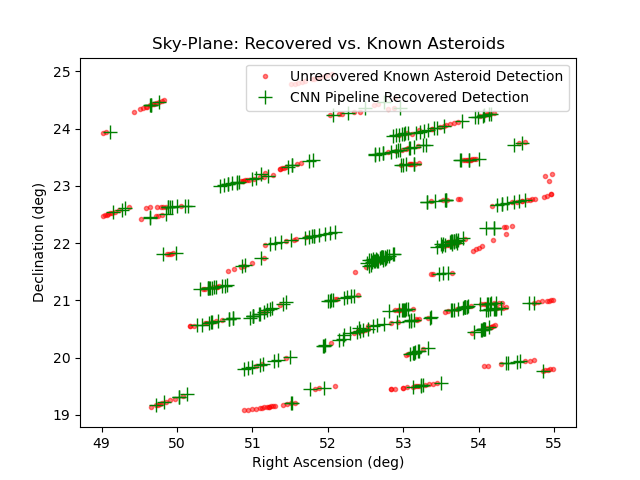

In [386]:
plt.figure()
# plt.plot(known_ras, known_decs, ".r", alpha=0.5, label="Known Asteroid")
plt.plot(unmatched_known_ras[(unmatched_known_mjds >= 59805.2) & (unmatched_known_mjds <= 59813.637)], unmatched_known_decs[(unmatched_known_mjds >= 59805.2) & (unmatched_known_mjds <= 59813.637)], ".r", alpha=0.5, label="Unrecovered Known Asteroid Detection")

plt.plot(matched_new_ras, matched_new_decs, "+g", alpha=1, markersize=10, label="CNN Pipeline Recovered Detection")


plt.xlabel("Right Ascension (deg)")
plt.ylabel("Declination (deg)")
plt.title("Sky-Plane: Recovered vs. Known Asteroids")
plt.legend()

In [414]:
len(known_decs)

583

# Load known MPC asteroids

In [1]:
import numpy as np

In [2]:
known_lines = np.load("WISE_MPC_Known_Lines_STSsearch.npy")

In [40]:
import numpy as np
known_ras = np.load("./known_asteroids_S1_Numbered_RAs.npy")
known_decs = np.load("./known_asteroids_S1_Numbered_Decs.npy")
known_mjds = np.load("./known_asteroids_S1_Numbered_MJDs.npy")


# Filter out Known Asteroids in this region

In [42]:
new_ras = np.load("./S1_v3_Results/pt4_RAs_CoordCNN.npy")
new_decs = np.load("./S1_v3_Results/pt4_Decs_CoordCNN.npy")
new_mjds = np.load("./S1_v3_Results/pt4MJDs_CoordCNN.npy")

In [43]:
import numpy as np

new_ras   = np.asarray(new_ras,   dtype=float)
new_decs  = np.asarray(new_decs,  dtype=float)
new_mjds  = np.asarray(new_mjds,  dtype=float)

known_ras  = np.asarray(known_ras,  dtype=float)[(known_mjds >= 59805.2) & (known_mjds <= 59813.637)]
known_decs = np.asarray(known_decs, dtype=float)[(known_mjds >= 59805.2) & (known_mjds <= 59813.637)]
known_mjds = np.asarray(known_mjds, dtype=float)[(known_mjds >= 59805.2) & (known_mjds <= 59813.637)]

tol_ra  = 0.011 #deg ~4 pixel
tol_dec = 0.011
tol_mjd = 5.787e-5#  5sec

matches = [] 
for ra, dec, mjd in zip(new_ras, new_decs, new_mjds):
    diff_ra  = np.abs(known_ras  - ra)
    diff_dec = np.abs(known_decs - dec)
    diff_mjd = np.abs(known_mjds - mjd)

    hit_mask = (diff_ra <= tol_ra) & (diff_dec <= tol_dec) & (diff_mjd <= tol_mjd)

    matches.append(np.nonzero(hit_mask)[0].tolist())

matched_mask   = np.array([len(m) > 0 for m in matches], dtype=bool)
unmatched_mask = ~matched_mask

In [73]:
import numpy as np

# Make sure new detections are arrays
new_ras  = np.asarray(new_ras, dtype=float)
new_decs = np.asarray(new_decs, dtype=float)
new_mjds = np.asarray(new_mjds, dtype=float)

# Tolerances
tol_ra  = 0.011  # deg ~4 pixels
tol_dec = 0.011  # deg ~4 pixels
tol_mjd = 5.787e-5  # ~5 sec

# Track recovered asteroids
recovered_flags = []

for asteroid in nested_array:
    match_count = 0
    for det in asteroid:
        ra, dec, mjd = det[1], det[2], det[3]

        diff_ra  = np.abs(new_ras  - ra)
        diff_dec = np.abs(new_decs - dec)
        diff_mjd = np.abs(new_mjds - mjd)

        hit_mask = (diff_ra <= tol_ra) & (diff_dec <= tol_dec) & (diff_mjd <= tol_mjd)

        if np.any(hit_mask):
            match_count += 1

    recovered_flags.append(match_count >= 4)

recovered_flags = np.array(recovered_flags)
percent_recovered = 100 * np.sum(recovered_flags) / len(recovered_flags)

print(f"Recovered {np.sum(recovered_flags)} out of {len(recovered_flags)} asteroids (≥NNN detections)")
print(f"Percentage recovered: {percent_recovered:.2f}%")


Recovered 21 out of 35 asteroids (≥NNN detections)
Percentage recovered: 60.00%


In [65]:
len(hit_mask)

583

In [46]:
import numpy as np

# Flatten all matched known indices from all new detections
all_matched_known = [idx for sublist in matches for idx in sublist]
all_matched_known = np.unique(all_matched_known)  # remove duplicates

# Count how many known detections were matched
n_known_total = len(known_ras)
n_known_matched = len(all_matched_known)

# Compute percentage
percent_matched = 100 * n_known_matched / n_known_total

print(f"Matched {n_known_matched} out of {n_known_total} known detections")
print(f"Percentage recovered: {percent_matched:.2f}%")


Matched 278 out of 583 known detections
Percentage recovered: 47.68%


# create match masks

In [44]:
matched_known_indices = set()
for m in matches:
    matched_known_indices.update(m)
    
all_known_indices = set(range(len(known_ras)))

unmatched_known_indices = list(all_known_indices - matched_known_indices)
unmatched_known_ras  = known_ras[unmatched_known_indices]
unmatched_known_decs = known_decs[unmatched_known_indices]
unmatched_known_mjds = known_mjds[unmatched_known_indices]

In [48]:
len(known_decs[(known_mjds >= 59805.2) & (known_mjds <= 59813.637)])

583

In [20]:
import numpy as np

matched_mask = np.fromiter((len(m) > 0 for m in matches), dtype=bool)

matched_new_ras   = new_ras[matched_mask]
matched_new_decs  = new_decs[matched_mask]
matched_new_mjds  = new_mjds[matched_mask]

matched_new_array = np.column_stack(
    (matched_new_ras, matched_new_decs, matched_new_mjds)
)

unique_matched_new = np.unique(matched_new_array, axis=0)

unique_ras, unique_decs, unique_mjds = unique_matched_new.T


In [21]:
unmatched_mask = ~matched_mask

unmatched_new_ras   = new_ras[unmatched_mask]
unmatched_new_decs  = new_decs[unmatched_mask]
unmatched_new_mjds  = new_mjds[unmatched_mask]

unmatched_new_array = np.column_stack(
    (unmatched_new_ras, unmatched_new_decs, unmatched_new_mjds)
)

unique_unmatched = np.unique(unmatched_new_array, axis=0)
unique_ras, unique_decs, unique_mjds = unique_unmatched.T


In [22]:
len(new_ras)

153226

In [102]:

# np.save("./unique_ras_v3_pt9.npy", unique_ras)
# np.save("./unique_decs_v3_pt9.npy", unique_decs)
# np.save("./unique_mjds_v3_pt9.npy", unique_mjds)

In [23]:
# ims = np.load("./Searches/v3_images_pt9.npy")
# pix_coords = np.load("./Searches/v3_predicted_CoordinatesPixels_pt9.npy")

# new_ims = ims[unmatched_mask]
# new_pix_coords = pix_coords[unmatched_mask]

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from matplotlib.patches import Circle
from kevlib.utils.plot import plot_images

def calculate_snr_normalized(image_data, position, aperture_radius, annulus_radii, sigma=0.2):
    aperture = CircularAperture(position, r=aperture_radius)
    annulus = CircularAnnulus(position, r_in=annulus_radii[0], r_out=annulus_radii[1])
    aperture_phot = aperture_photometry(image_data, aperture)
    signal = aperture_phot['aperture_sum'][0]
    
    annulus_phot = aperture_photometry(image_data, annulus)
    bkg_mean = annulus_phot['aperture_sum'][0] / annulus.area
    bkg_total = bkg_mean * aperture.area
    net_signal = signal - bkg_total
    
    N_pixels = aperture.area
    total_noise = sigma * np.sqrt(N_pixels)
    
    snr = net_signal / total_noise if total_noise != 0 else 0
    
    return snr


import matplotlib.pyplot as plt

import matplotlib.patches as patches

def plot_with_circles(images, coords, nrows=10, ncols=10):
    
    subset_images= images
    
    num_plots = nrows * nrows
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*nrows, 3*ncols))
    axes = axes.flatten()
    
    for i in range(num_plots):
        ax = axes[i]
        if i >= len(subset_images):
            ax.axis('off')
            continue
        
        # Show the image
        img_2d = subset_images[i, :, :]
        ax.imshow(img_2d, origin='lower', cmap='gray')
    
        # Draw the predicted coordinate as a red circle
        x_pred, y_pred = coords[i]
        circle = patches.Circle((x_pred, y_pred), radius=2.0, fill=False,
                                edgecolor='red', linewidth=2)
        ax.add_patch(circle)
    
        ax.set_xlim(-0.5, 14.5)
        ax.set_ylim(-0.5, 14.5)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

In [28]:
# known_ims = ims[matched_mask]
# known_pix_coords = np.load("./Searches/v3_predicted_CoordinatesPixels_pt4.npy")
# known_pix_coords = known_pix_coords[matched_mask]
# knowns_SNRs = [calculate_snr_normalized(im, position=(center[0], center[1]), aperture_radius=2, annulus_radii=[3,4]) for im, center in zip(known_ims, known_pix_coords)]

# unknown_ims = ims[~matched_mask]
# unknown_pix_coords = np.load("./Searches/v3_predicted_CoordinatesPixels_pt4.npy")
# unknown_pix_coords = unknown_pix_coords[~matched_mask]
# unknowns_SNRs = [calculate_snr_normalized(im, position=(center[0], center[1]), aperture_radius=2, annulus_radii=[3,4]) for im, center in zip(unknown_ims, unknown_pix_coords)]

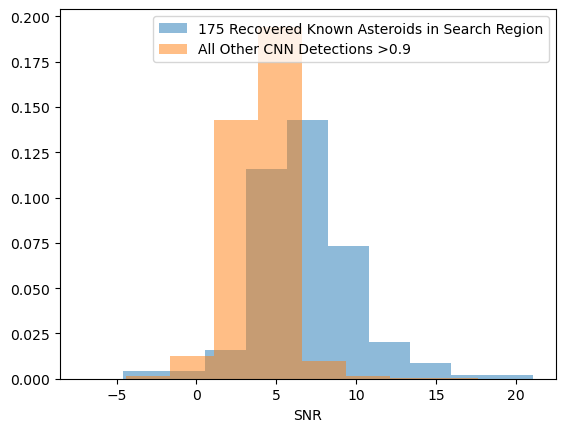

In [202]:
plt.figure()
plt.hist(knowns_SNRs, density=True, alpha=0.5, label="175 Recovered Known Asteroids in Search Region")
plt.hist(unknowns_SNRs, density=True, alpha=0.5, label="All Other CNN Detections >0.9")
plt.xlabel("SNR")
plt.legend()

In [31]:
# known_pix_coords = np.load("./Searches/v3_predicted_CoordinatesPixels_pt4.npy")

# len(known_pix_coords)
# 3sho

In [23]:
low=3
hi=4
knowns_SNRs = np.array(knowns_SNRs)
plot_with_circles(known_ims[(knowns_SNRs >= low) & (knowns_SNRs <= hi)], known_pix_coords[(knowns_SNRs >= low) & (knowns_SNRs <= hi)], nrows=10, ncols=10)


In [57]:
len(known_lines)

3859777

# Plot known asteroid chains from MPC data

In [16]:
len(r)

591

In [22]:
# Load Object id's into array.
# len(lines)

In [7]:
from astropy.io import fits

In [8]:
import numpy as np
import pandas as pd

cnn_urls = np.load("./Searches/S1_URLs.npy")
cnn_urls = np.unique(cnn_urls)
cnn_mjds = [fits.open(u)[0].header["MJD_OBS"] for u in cnn_urls]

known_lines = np.load("WISE_MPC_Known_Lines_STSsearch.npy")
objids = [line[:6] for line in known_lines]
r = np.load("./known_asteroids_S1_Numbered_RAs.npy")
d = np.load("./known_asteroids_S1_Numbered_Decs.npy")
m = np.load("./known_asteroids_S1_Numbered_MJDs.npy")

data = {
    "objid": objids,
    "ra": r,
    "dec": d,
    "mjd": m
}

df = pd.DataFrame(data)
print(df.head(5))

df = df.loc[(df["mjd"] >= min(cnn_mjds)) & (df["mjd"] <= max(cnn_mjds))]
print(df.head(5))

grouped_rows = (
    df
    .groupby(by='objid', sort=False)
    .filter(lambda g: len(g) >= 4)
    .groupby(by='objid', sort=False)
    .apply(lambda g: g.to_numpy().tolist())
    .to_list()
)

nested_array = np.array(grouped_rows, dtype=object)

urls = np.load("./Searches/S1_URLs.npy")
urls = np.unique(urls)
len(urls)

    objid         ra        dec           mjd
0  00244   50.882917  19.079222  59805.871887
1  00244   50.938167  19.089944  59806.002269
2  00244   50.993417  19.100667  59806.132674
3  00244   51.048667  19.111361  59806.263067
4  00244   51.103833  19.122028  59806.393588
    objid         ra        dec           mjd
0  00244   50.882917  19.079222  59805.871887
1  00244   50.938167  19.089944  59806.002269
2  00244   50.993417  19.100667  59806.132674
3  00244   51.048667  19.111361  59806.263067
4  00244   51.103833  19.122028  59806.393588


/tmp/ipykernel_20064/4268392347.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.to_numpy().tolist())


755

In [9]:
nested_array[0]

[['00244 ', 50.88291666666666, 19.07922222222222, 59805.871886574074],
 ['00244 ', 50.93816666666666, 19.089944444444445, 59806.00226851852],
 ['00244 ', 50.99341666666666, 19.10066666666667, 59806.13267361111],
 ['00244 ', 51.048666666666655, 19.111361111111112, 59806.26306712963],
 ['00244 ', 51.10383333333333, 19.122027777777777, 59806.393587962964],
 ['00244 ', 51.13137499999999, 19.127388888888888, 59806.45878472222],
 ['00244 ', 51.158958333333324, 19.132638888888888, 59806.523981481485],
 ['00244 ', 51.18641666666666, 19.137999999999998, 59806.58917824074],
 ['00244 ', 51.21391666666666, 19.14322222222222, 59806.654375],
 ['00244 ', 51.21391666666666, 19.143333333333334, 59806.654502314814],
 ['00244 ', 51.24145833333333, 19.148555555555554, 59806.71969907408],
 ['00244 ', 51.268874999999994, 19.15386111111111, 59806.784895833334],
 ['00244 ', 51.29641666666666, 19.159055555555554, 59806.85009259259],
 ['00244 ', 51.40608333333332, 19.18005555555556, 59807.11100694445],
 ['00244

In [9]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
import numpy as np
from tqdm import tqdm

url_mjds = [fits.open(url)[0].header["MJD_OBS"] for url in urls]

def square_index(x_pix: int, y_pix: int,
                 square_size: int = 15,
                 image_width: int = 1016,
                 image_height: int = 1016):

    num_x = image_width  // square_size
    num_y = image_height // square_size

    if x_pix >= num_x * square_size or y_pix >= num_y * square_size:
        return None

    i = x_pix // square_size
    j = y_pix // square_size
    return i * num_y + j

im_ind = []
all_chain_inds = []
pixel_pos = []

for i in tqdm(range(len(nested_array))):
    chain_inds = []
    
    for s in range(len(nested_array[i])):

        num_urls = 0
        
        for j, url in enumerate(urls):
        
            if abs(url_mjds[j] - nested_array[i][s][3]) < 0.0001:
                hdul = fits.open(url)
                hdul[0].header.rename_keyword('RADECSYS', 'RADESYS')
                header = hdul[0].header
                wcs = WCS(header)
                c = SkyCoord(nested_array[i][s][1], nested_array[i][s][2], frame='icrs', unit='deg')
                x0, y0 = wcs.world_to_pixel(c)      
                pixel_pos.append([x0, y0])
                ind = square_index(x0, y0)

                if ind is not None:
                
                    num_prev_frames = num_urls*4489
                    
                    final_ind = ind + num_prev_frames
                    
                    chain_inds.append(final_ind)

                break
            num_urls+=1

    all_chain_inds.append(chain_inds)

100%|██████████| 35/35 [00:16<00:00,  2.15it/s]


In [35]:
nested_array[0]

[['00244 ', 50.88291666666666, 19.07922222222222, 59805.871886574074],
 ['00244 ', 50.93816666666666, 19.089944444444445, 59806.00226851852],
 ['00244 ', 50.99341666666666, 19.10066666666667, 59806.13267361111],
 ['00244 ', 51.048666666666655, 19.111361111111112, 59806.26306712963],
 ['00244 ', 51.10383333333333, 19.122027777777777, 59806.393587962964],
 ['00244 ', 51.13137499999999, 19.127388888888888, 59806.45878472222],
 ['00244 ', 51.158958333333324, 19.132638888888888, 59806.523981481485],
 ['00244 ', 51.18641666666666, 19.137999999999998, 59806.58917824074],
 ['00244 ', 51.21391666666666, 19.14322222222222, 59806.654375],
 ['00244 ', 51.21391666666666, 19.143333333333334, 59806.654502314814],
 ['00244 ', 51.24145833333333, 19.148555555555554, 59806.71969907408],
 ['00244 ', 51.268874999999994, 19.15386111111111, 59806.784895833334],
 ['00244 ', 51.29641666666666, 19.159055555555554, 59806.85009259259],
 ['00244 ', 51.40608333333332, 19.18005555555556, 59807.11100694445],
 ['00244

In [36]:
import numpy as np

motion_rates = []
for chain in nested_array:
    if len(chain) < 2:
        motion_rates.append(np.nan)
        continue

    ra1, dec1, mjd1 = chain[0][1], chain[0][2], chain[0][3]
    ra2, dec2, mjd2 = chain[-1][1], chain[-1][2], chain[-1][3]

    dt_days = mjd2 - mjd1
    if dt_days <= 0:
        motion_rates.append(np.nan)
        continue

    dra = (ra2 - ra1) * np.cos(np.radians((dec1 + dec2)/2))
    ddec = (dec2 - dec1)
    distance_deg=np.sqrt(dra**2 + ddec**2)

    rate_deg_per_day = distance_deg / dt_days
    motion_rates.append(rate_deg_per_day)

motion_rates = np.array(motion_rates)
print("Average motion rate (deg/day):", np.nanmean(motion_rates))


Average motion rate (deg/day): 0.34770353197639337


In [39]:
np.save("known_asteroid_S1_motion_rates_from_crosscheckMPCnbk", motion_rates)

In [27]:
len(all_ims)

3389195

In [32]:
c = [c for a in all_chain_inds for c in a]

In [12]:
# all_chain_inds

In [ ]:
from kevlib.utils.io import mmcreate, mmload

# all_ims = np.load("./Searches/2_S1_initial_deploy_grids_W1.npy") # W1 successful!
all_ims = np.load("./w2_s1_initialgrids.npy") # W1 successful!
# all_ims = np.load("./Searches/2_.npy") # W1 successful!

all_confs = np.load("./Searches/v3_all_confidences_S1.npy")

all_chain_ims = []
all_chain_confs = []
for i in range(len(all_chain_inds)):
    chain_ims = []
    chain_confs = []
    for j in range(len(all_chain_inds[i])):
        chain_ims.append(all_ims[int(all_chain_inds[i][j])])
        chain_confs.append(all_confs[int(all_chain_inds[i][j])])
    all_chain_ims.append(chain_ims)
    all_chain_confs.append(chain_confs)

In [57]:
# n= [j for i in nested_array for j in i]
# nested_array

In [27]:
import numpy as np

# Load arrays
all_ims = np.load("./w2_s1_initialgrids.npy")  
all_confs = np.load("./Searches/v3_all_confidences_S1.npy")

# Flatten directly instead of creating nested lists
flat_chain_ims = [all_ims[int(idx)] for chain in all_chain_inds for idx in chain]
flat_chain_confs = [all_confs[int(idx)] for chain in all_chain_inds for idx in chain]


In [31]:
np.save("known_asteroids_mpc_irsa_S1_sts_ims_w2", flat_chain_ims)
np.save("known_asteroids_mpc_irsa_S1_sts_coords_w2", pixel_pos)

In [33]:
# pixel_pos[0]

In [15]:
len(pixel_pos)

458

# Calculate SNR of known asteroids

In [18]:
b = np.load("./Searches/2_S1_DarkPixelsRemoved_Normalized_FinalDeployGrids.npy")
# a = np.load("./Searches/2_S1_DarkPixelsRemoved_Normalized_initial_deploy_grids.npy")

In [24]:
np.std(b[120])

0.18927513

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

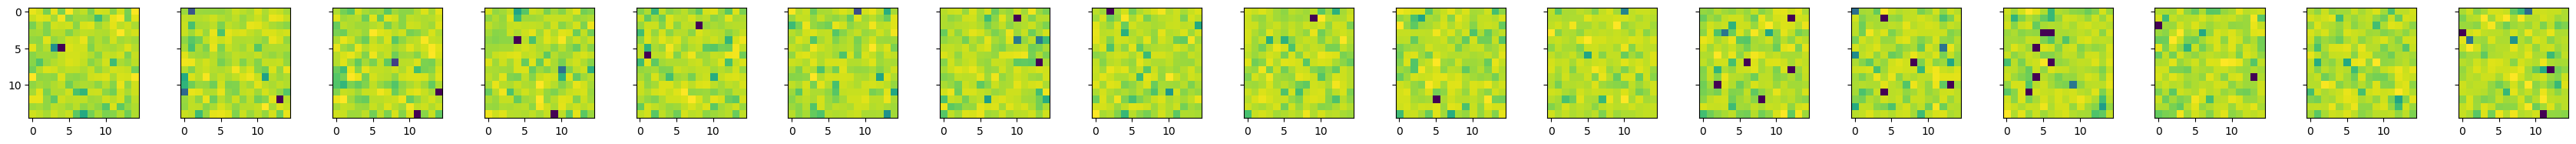

In [28]:
from kevlib.utils.plot import plot_images

plot_images(all_chain_ims[0], fig_height=2)

In [16]:
len(W1ims) == len(W2ims)

True

In [50]:
len(pos_confidences)

3389195

In [60]:
good_speed_chains = [[int(s) for s in c] for c in all_chain_inds]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# predictedCoords  = np.load("./unique_pixCoords_v3_pt4.npy")
W2ims = np.load("./w2_s1_initialgrids.npy")
W1ims = np.load("./Searches/2_S1_initial_deploy_grids_W1.npy")
pos_confidences = np.load("./Searches/v3_all_confidences_S1.npy")

circle_radius = 2

row_titles    = ['W1ims', "W2ims"]
image_arrays  = [W1ims, W2ims]
n_rows        = len(image_arrays)

pdf_filename = 'KnownMPCAsteroids_S1region_W1andW2_Images.pdf'
with PdfPages(pdf_filename) as pdf:
    for chain_idx, chain in enumerate(good_speed_chains[0:10]):
        n = len(chain)
        if n < 1:
            continue

        
        fig, axes = plt.subplots(
            n_rows, n,
            figsize=(n * 3, n_rows * 3),
            squeeze=False
        )

        for col, img_idx in enumerate(chain):
            conf = pos_confidences[img_idx]
            axes[0, col].set_title(f"Confidence: {conf:.2f}", fontsize=10)

            for row in range(n_rows):
                ax  = axes[row, col]
                img = image_arrays[row][img_idx]

                ax.imshow(img, cmap='gray', origin='lower')  # origin='lower' → (0,0) bottom-left
                ax.axis('off')

                # draw predicted coordinate
                # x, y = predictedCoords[img_idx]
                # circ = plt.Circle((x, y), radius=circle_radius,
                #                   edgecolor='red', facecolor='none', linewidth=2)
                # ax.add_patch(circ)

                if col == 0:
                    ax.set_ylabel(row_titles[row], fontsize=12)

        fig.suptitle(f"Chain {chain_idx}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved as '{pdf_filename}'")

PDF saved as 'KnownMPCAsteroids_S1region_W1andW2_Images.pdf'


In [22]:
plt.close()

In [ ]:
# MPC asteroids' time differences

In [25]:
# nested_array[0]

In [1]:
nested_array[0]

NameError: name 'nested_array' is not defined

In [282]:
?np.dist

Object `np.dist` not found.


In [298]:
speeds = []
for arr in nested_array:
    c_speeds = []
    for i in range(1, len(arr)):
    
        p1 = (arr[i][1], arr[i][2])
        
        p2 = (arr[i-1][1], arr[i-1][2] )
    
        t = arr[i][3] - arr[i-1][3]
        c_speeds.append(math.dist(p1, p2) / t)
    speeds.append(c_speeds)
    

In [346]:
diffs = []
for x in range(len(nested_array)):
    c_diffs = []
    for i in range(1,len(nested_array[x])):
        c_diffs.append(nested_array[x][i][3] - nested_array[x][i-1][3])
    diffs.append(c_diffs)

In [349]:
# diffs

In [351]:
avg_diffs = []
for c in diffs:
    s = 0
    for d in c:
        s += d
    
    avg_diffs.append(s / len(c))

avg_speeds = []
for c in speeds:
    s = 0
    for d in c:
        s += d
    
    avg_speeds.append(s / len(c))


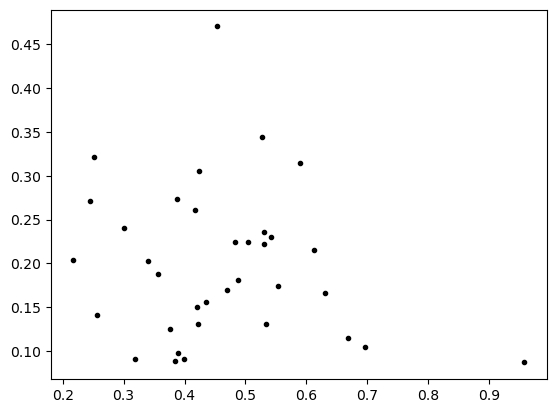

In [352]:
plt.figure()
plt.plot(avg_speeds, avg_diffs , ".k")

In [345]:
plt.figure()
diffs = np.array(diffs)
plt.hist(diffs[diffs<1], bins=12)
plt.xlabel("time difference (days)")

In [293]:
speeds

[0.4316610028719301,
 0.3933328643907414,
 0.26396600065143705,
 0.2539797474631764,
 0.29429911293045974,
 0.26105863225100984,
 0.8485281168873496,
 0.4364430678157388,
 2.3925504093719865,
 0.2677921830586673,
 0.46516051103896305,
 0.446935010495127,
 0.34587389664264667,
 0.26123533522149794,
 0.3808561319857342,
 0.33277198199366015,
 0.42646504876321567,
 0.3588121954659128,
 0.25768379274819964,
 0.4750194006453578,
 0.4234068778532943,
 0.43202563685691575,
 0.36792669292636815,
 0.3769424136735442,
 0.6352142309313642,
 0.28815927482540915,
 0.3858450640049334,
 0.47173110309836813,
 0.3998003531330465,
 0.5445773162857606,
 0.4182291150870946,
 0.4277791912557158,
 0.45406559784513534,
 0.4087699516903677,
 0.3866595036274916]

In [19]:
nested_array[24]

[['39741 ', 52.02258333333333, 24.239055555555556, 59811.34994212963],
 ['39741 ', 52.06366666666666, 24.24427777777778, 59811.415138888886],
 ['39741 ', 52.1455, 24.255444444444443, 59811.54553240741],
 ['39741 ', 52.185916666666664, 24.261027777777777, 59811.61072916666],
 ['39741 ', 52.268208333333334, 24.271833333333333, 59811.74125],
 ['39741 ', 52.34954166666667, 24.282805555555555, 59811.87165509259],
 ['39741 ', 52.430833333333325, 24.293833333333335, 59812.00204861111],
 ['39741 ', 52.796166666666664, 24.34161111111111, 59812.58907407407],
 ['39741 ', 52.87674999999999, 24.35177777777778, 59812.71946759259],
 ['39741 ', 52.95841666666666, 24.362194444444444, 59812.84998842593]]